five# RFM-BASED PRODUCT RECOMMENDATION SYSTEM
Leveraging K-Medoids Clustering for Personalized Product Recommendations
RECOMMENDATION SYSTEM TYPE:
   Primary: Content-Based Filtering (RFM customer attributes)
   Secondary: Collaborative Filtering (segment-level patterns)
   Tertiary: Knowledge-Based Rules (business strategies)
   
   Result: HYBRID recommendation system combining all five approaches


   1️⃣ CLUSTERING (K-Medoids)                                      
│     Input: RFM values (Recency, Frequency, Monetary)            
│     Output: 5 customer segments                                 
│     Algorithm: K-Medoids with Minkowski distance (p=3)          
│                                                                   
│  2️⃣ SEGMENT-LEVEL PATTERN ANALYSIS                              
│     Collaborative Filtering Component                            
│     • Calculate product adoption rates per segment               
│     • Compute affinity scores (segment_rate / overall_rate)      
│     • Logic: "Customers like you also bought..."                 
│                                                                   
│  3️⃣ CUSTOMER-LEVEL SCORING                                      
│     Content-Based Component                                      
│     • RFM percentile ranking within segment                      
│     • Engagement score normalization                             
│     • Portfolio diversification score                            
│                                                                   
│  4️⃣ WEIGHTED HYBRID COMBINATION                                 
│     final_score = Σ (weight_i × component_i)                     
│                                                                   
│     Weights (segment-specific):                                  
│     • Affinity: 0.4-0.6     (collaborative signal)               
│     • RFM: 0.2-0.3          (customer quality)                   
│     • Engagement: 0.1-0.2   (behavior)                           
│     • Portfolio: 0.1        (diversification)                    
│     • Bonuses: tier + adoption (0-0.4)                           
│                                                                   
│  5️⃣ RANKING & SELECTION                                         
│     • Rank all products by score                                 
│     • Select top 3 recommendations per customer                  
│     • Calculate confidence (score gap between rec 1 & 2)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import percentileofscore
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load customer data
customer_df = pd.read_parquet('/content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/project_dataset/final_features.parquet')

# Load RFM clustering results
rfm_df = pd.read_parquet('/content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/RFM/rfm_clusters.parquet')

print(f"\n   Customer data: {len(customer_df):,} customers")
print(f"   RFM data: {len(rfm_df):,} customers")

# Merge datasets
customer_analysis = customer_df.merge(
    rfm_df[['customer_id', 'recency', 'frequency', 'monetary', 'cluster', 'cluster_name']],
    on='customer_id',
    how='inner'  # Only keep customers with RFM segments
)

print(f"\n   Merged dataset: {len(customer_analysis):,} customers")


   Customer data: 136,372 customers
   RFM data: 104,898 customers

   Merged dataset: 104,898 customers


In [ ]:
# Filter to active customers with cluster assignments
customer_analysis = customer_analysis[
    (customer_analysis['cluster_name'].notna()) &
    (customer_analysis['activity_status'] == 1)  # Active customers only
].copy()

print(f"   Active customers with segments: {len(customer_analysis):,}")

# Display segment distribution
print(f"\nCustomer Distribution by RFM Segment:")
segment_dist = customer_analysis['cluster_name'].value_counts()
for segment, count in segment_dist.items():
    pct = count / len(customer_analysis) * 100
    print(f"   {segment:20s}: {count:6,} ({pct:5.2f}%)")

   Active customers with segments: 77,065

Customer Distribution by RFM Segment:
   Core Customers      : 30,737 (39.88%)
   Champions           : 27,173 (35.26%)
   Hibernating         : 14,145 (18.35%)
   VIP Champions       :  3,070 ( 3.98%)
   New Joiners         :  1,940 ( 2.52%)


In [ ]:
customer_analysis.head()

,customer_id,residence_country,gender,age,first_join_date,residence_index,channel_entrance,activity_status,household_gross_income,saving_account,...,norm_growth,norm_diversity,norm_frequency,engagement_score,engagement_category,recency,frequency,monetary,cluster,cluster_name
0,15891,ES,0,59,2020-07-28,Y,KAT,1,122813.94,0,...,0.000000,0.066667,0.071429,0.029698,Very Low,10.133333,1.0,341.33,3,New Joiners
1,15899,ES,1,57,2000-01-16,Y,KAT,1,130835.64,0,...,0.400000,0.400000,0.428571,0.271758,Low,260.100000,6.0,14823.15,4,Hibernating
2,15900,ES,1,48,2000-01-16,Y,KAT,1,105327.03,0,...,0.200000,0.266667,0.035294,0.148321,Very Low,260.100000,7.0,2524.94,4,Hibernating
3,15902,ES,0,57,2000-01-16,Y,KAT,1,230408.25,0,...,0.066667,0.133333,0.142857,0.082860,Very Low,260.100000,2.0,10218.54,4,Hibernating
4,15906,ES,0,55,2006-02-16,Y,KAT,1,81005.49,0,...,0.400000,0.533333,0.070169,0.444838,Medium,186.000000,13.0,152711.31,2,VIP Champions


In [ ]:
customer_analysis.columns

Index(['customer_id', 'residence_country', 'gender', 'age', 'first_join_date',
       'residence_index', 'channel_entrance', 'activity_status',
       'household_gross_income', 'saving_account', 'guarantees',
       'junior_account', 'loans', 'credit_card', 'pensions', 'direct_debit',
       'mortgage', 'employment_status', 'employment_status_int',
       'personal_income', 'current_loan_amount', 'credit_score',
       'customer_segment_model', 'years_calc', 'total_products_owned',
       'junior_guarantee', 'customer_tenure_months', 'current_products_owned',
       'total_adoptions', 'portfolio_value', 'avg_adoption_value',
       'adoption_value_std', 'total_cancellations', 'net_product_growth',
       'product_churn_rate', 'adoption_value_cv', 'category_diversity',
       'product_diversity', 'active_months', 'adoption_frequency',
       'avg_days_between_adoptions', 'norm_adoptions', 'norm_portfolio',
       'norm_growth', 'norm_diversity', 'norm_frequency', 'engagement_score',
   

In [ ]:
customer_analysis[['customer_id','current_products_owned','total_products_owned','total_adoptions','net_product_growth']]

,customer_id,current_products_owned,total_products_owned,total_adoptions,net_product_growth
0,15891,0,0,1.0,0.0
1,15899,2,2,6.0,6.0
2,15900,1,1,7.0,3.0
3,15902,0,0,2.0,1.0
4,15906,2,1,13.0,6.0
...,...,...,...,...,...
104893,402685,1,1,5.0,2.0
104894,402686,0,0,2.0,2.0
104895,402687,0,0,2.0,2.0
104896,402691,2,2,4.0,3.0


In [ ]:
# ============================================================================
# Verify Pre-Calculated Features
# ============================================================================


# Define products based on your columns
products = [
    'saving_account',
    'guarantees',
    'junior_account',
    'loans',
    'credit_card',
    'pensions',
    'direct_debit',
    'mortgage'
]

print(f"\nBanking Products: {len(products)}")
for product in products:
    if product in customer_analysis.columns:
        print(f" {product}")
    else:
        print(f" {product} - MISSING!")

# Verify pre-calculated features
required_features = [
    'current_products_owned',
    'total_products_owned',
    'total_adoptions',
    'net_product_growth',
    'adoption_frequency',
    'portfolio_value',
    'engagement_score'
]

print(f"\n Pre-Calculated Features:")
for feature in required_features:
    if feature in customer_analysis.columns:
        mean_val = customer_analysis[feature].mean()
        print(f" {feature:30s}: Mean = {mean_val:.2f}")
    else:
        print(f" {feature:30s}: NOT FOUND")

# Display sample
print(f"\nSample Customer Data:")
sample_cols = ['customer_id', 'cluster_name', 'recency', 'frequency', 'monetary',
               'current_products_owned', 'total_adoptions', 'engagement_score']
print(customer_analysis[sample_cols].head(10).to_string(index=False))


Banking Products: 8
 saving_account
 guarantees
 junior_account
 loans
 credit_card
 pensions
 direct_debit
 mortgage

 Pre-Calculated Features:
 current_products_owned        : Mean = 0.71
 total_products_owned          : Mean = 0.68
 total_adoptions               : Mean = 5.04
 net_product_growth            : Mean = 3.44
 adoption_frequency            : Mean = 1.84
 portfolio_value               : Mean = 11318.30
 engagement_score              : Mean = 0.16

Sample Customer Data:
 customer_id  cluster_name    recency  frequency  monetary  current_products_owned  total_adoptions  engagement_score
       15891   New Joiners  10.133333        1.0    341.33                       0              1.0          0.029698
       15899   Hibernating 260.100000        6.0  14823.15                       2              6.0          0.271758
       15900   Hibernating 260.100000        7.0   2524.94                       1              7.0          0.148321
       15902   Hibernating 260.100000   


 Product Adoption Rates by RFM Segment:
                saving_account  guarantees  junior_account  loans  \
cluster_name                                                        
Champions                0.001         0.0           0.000  0.005   
Core Customers           0.001         0.0           0.005  0.004   
Hibernating              0.001         0.0           0.000  0.004   
New Joiners              0.000         0.0           0.000  0.001   
VIP Champions            0.001         0.0           0.000  0.007   

                credit_card  pensions  direct_debit  mortgage  
cluster_name                                                   
Champions             0.418     0.086         0.745     0.000  
Core Customers        0.048     0.027         0.138     0.000  
Hibernating           0.100     0.054         0.268     0.000  
New Joiners           0.180     0.073         0.243     0.000  
VIP Champions         0.412     0.079         0.879     0.985  


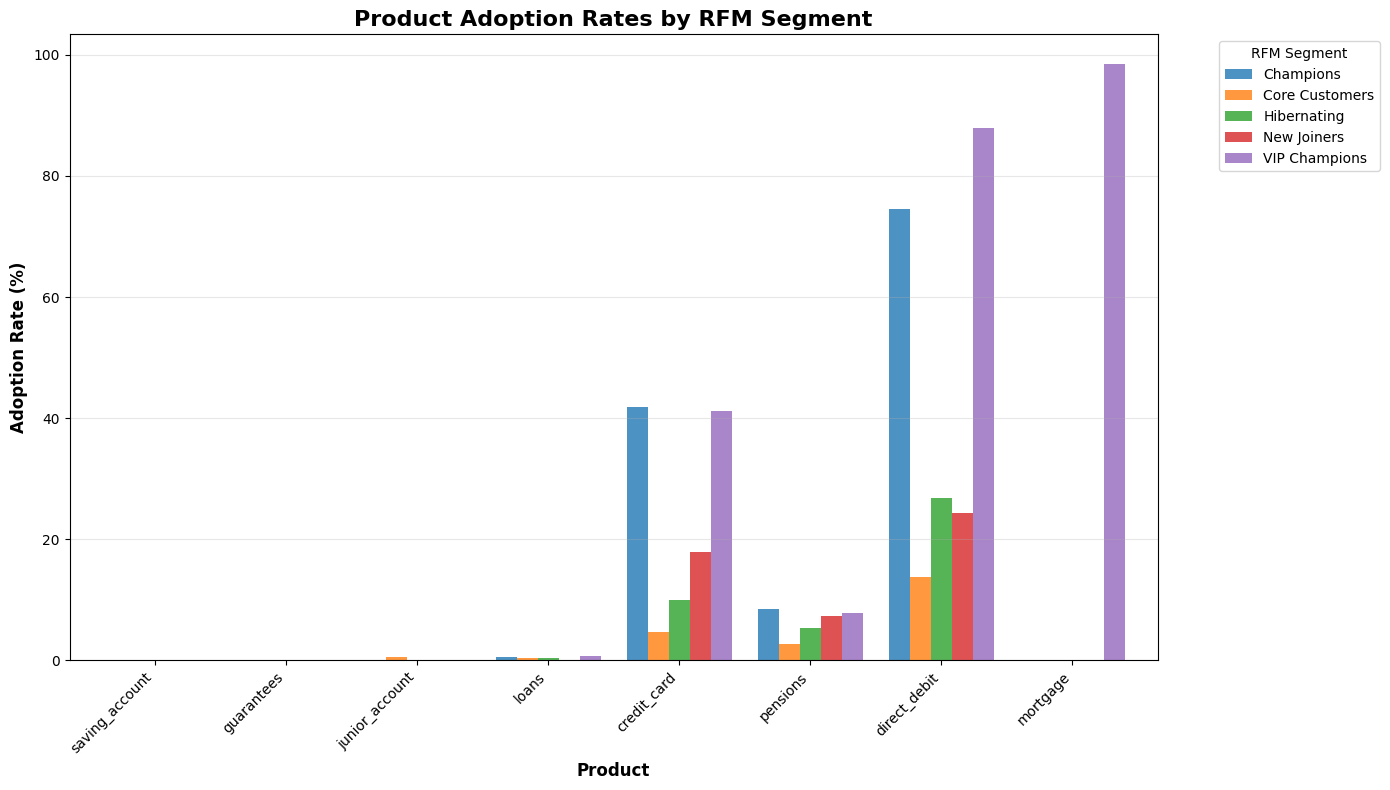

In [ ]:
# ============================================================================
# Calculate Product Adoption by RFM Segment
# ============================================================================


# Calculate adoption rates by segment
segment_product_adoption = customer_analysis.groupby('cluster_name')[products].mean()

print(f"\n Product Adoption Rates by RFM Segment:")
print(segment_product_adoption.round(3))

# Visualize
fig, ax = plt.subplots(figsize=(14, 8))
segment_product_adoption_pct = segment_product_adoption * 100
segment_product_adoption_pct.T.plot(kind='bar', ax=ax, width=0.8, alpha=0.8)
ax.set_xlabel('Product', fontsize=12, fontweight='bold')
ax.set_ylabel('Adoption Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Product Adoption Rates by RFM Segment', fontsize=16, fontweight='bold')
ax.legend(title='RFM Segment', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# plt.savefig('/content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/rfm_segment_product_adoption.png',
            # dpi=300, bbox_inches='tight')
plt.show()




In [ ]:
# Summary statistics by segment
print(f"\n Segment-Level Product Portfolio Summary:")
segment_summary = customer_analysis.groupby('cluster_name').agg({
    'customer_id': 'count',
    'current_products_owned': 'mean',
    'total_adoptions': 'mean',
    'portfolio_value': 'mean',
    'engagement_score': 'mean',
    'net_product_growth': 'mean'
}).round(2)
segment_summary.columns = ['Customer_Count', 'Avg_Products', 'Avg_Adoptions',
                            'Avg_Portfolio_Value', 'Avg_Engagement', 'Avg_Net_Growth']
print(segment_summary.to_string())


 Segment-Level Product Portfolio Summary:
                Customer_Count  Avg_Products  Avg_Adoptions  Avg_Portfolio_Value  Avg_Engagement  Avg_Net_Growth
cluster_name                                                                                                    
Champions                27173          1.26           8.75             11778.68            0.24            5.30
Core Customers           30737          0.22           2.51              2996.74            0.10            2.10
Hibernating              14145          0.43           2.95              4016.03            0.11            2.39
New Joiners               1940          0.50           3.36              4912.59            0.10            2.10
VIP Champions             3070          2.36           8.13            128252.50            0.38            5.98


Product Affinity = Segment Adoption Rate / Overall Adoption Rate
Affinity > 1.0 = Segment over-indexes on this product
Affinity < 1.0 = Segment under-indexes on this product

In [ ]:
#============================================================================
# Calculate Product Affinity Scores by Segment
# ============================================================================

# Calculate overall adoption rates
overall_adoption = customer_analysis[products].mean()

print(f"\n Overall Product Adoption Rates:")
for product, rate in overall_adoption.items():
    count = customer_analysis[product].sum()
    print(f"   {product:20s}: {rate*100:5.2f}% ({count:,} customers)")

# Calculate affinity (segment rate / overall rate)
product_affinity = segment_product_adoption.div(overall_adoption, axis=1)

print(f"\nProduct Affinity Scores by Segment:")
print(product_affinity.round(2))


 Overall Product Adoption Rates:
   saving_account      :  0.06% (47 customers)
   guarantees          :  0.01% (10 customers)
   junior_account      :  0.21% (162 customers)
   loans               :  0.45% (346 customers)
   credit_card         : 20.58% (15,863 customers)
   pensions            :  5.60% (4,314 customers)
   direct_debit        : 40.81% (31,449 customers)
   mortgage            :  3.92% (3,023 customers)

Product Affinity Scores by Segment:
                saving_account  guarantees  junior_account  loans  \
cluster_name                                                        
Champions                 1.21        2.27            0.21   1.21   
Core Customers            0.91        0.25            2.32   0.84   
Hibernating               0.93        0.54            0.00   0.91   
New Joiners               0.00        0.00            0.00   0.11   
VIP Champions             1.07        0.00            0.00   1.67   

                credit_card  pensions  direct_debit  

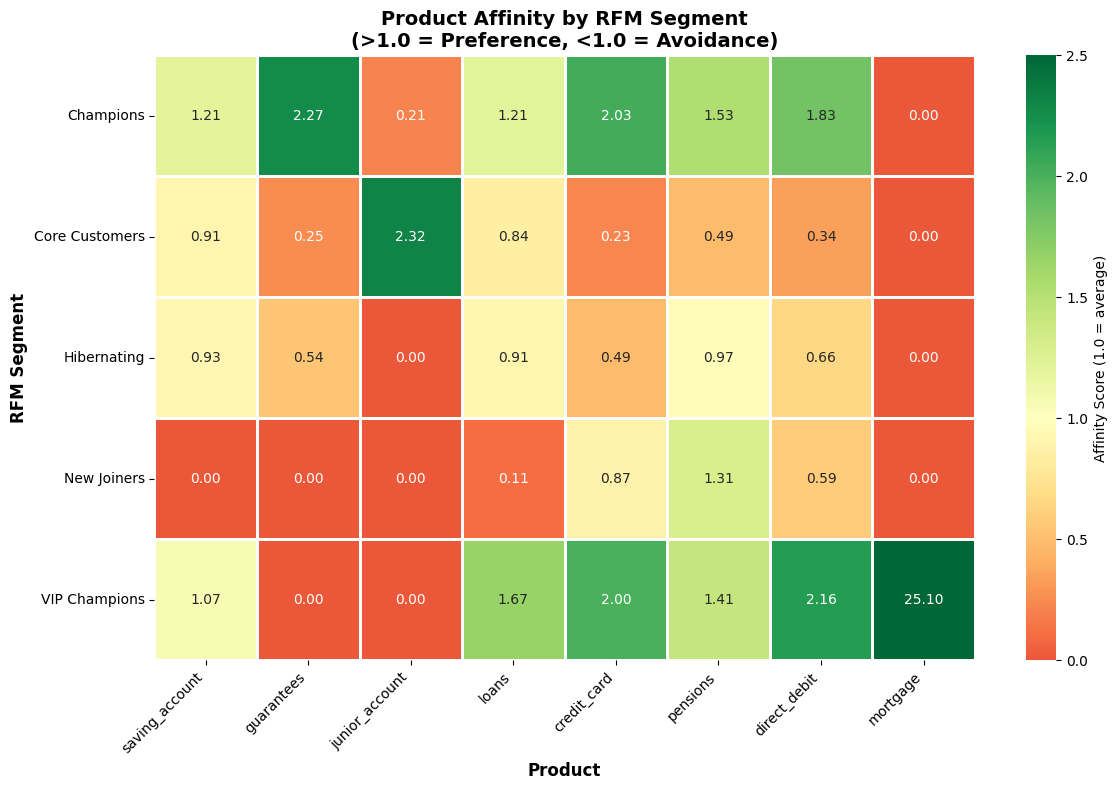

In [ ]:
# Visualize affinity heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(product_affinity, annot=True, fmt='.2f', cmap='RdYlGn',
            center=1.0, vmin=0, vmax=2.5, linewidths=1, ax=ax,
            cbar_kws={'label': 'Affinity Score (1.0 = average)'})
ax.set_title('Product Affinity by RFM Segment\n(>1.0 = Preference, <1.0 = Avoidance)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Product', fontsize=12, fontweight='bold')
ax.set_ylabel('RFM Segment', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# plt.savefig('/content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/product_affinity_heatmap.png',
            # dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
# Identify top affinity products per segment
print(f"\n Top 3 Affinity Products per Segment:")
for segment in product_affinity.index:
    top_3 = product_affinity.loc[segment].nlargest(3)
    print(f"\n{segment}:")
    for product, affinity in top_3.items():
        adoption_rate = segment_product_adoption.loc[segment, product]
        print(f"   {product:20s}: Affinity={affinity:.2f}x (Adoption={adoption_rate*100:.1f}%)")


 Top 3 Affinity Products per Segment:

Champions:
   guarantees          : Affinity=2.27x (Adoption=0.0%)
   credit_card         : Affinity=2.03x (Adoption=41.8%)
   direct_debit        : Affinity=1.83x (Adoption=74.5%)

Core Customers:
   junior_account      : Affinity=2.32x (Adoption=0.5%)
   saving_account      : Affinity=0.91x (Adoption=0.1%)
   loans               : Affinity=0.84x (Adoption=0.4%)

Hibernating:
   pensions            : Affinity=0.97x (Adoption=5.4%)
   saving_account      : Affinity=0.93x (Adoption=0.1%)
   loans               : Affinity=0.91x (Adoption=0.4%)

New Joiners:
   pensions            : Affinity=1.31x (Adoption=7.3%)
   credit_card         : Affinity=0.87x (Adoption=18.0%)
   direct_debit        : Affinity=0.59x (Adoption=24.3%)

VIP Champions:
   mortgage            : Affinity=25.10x (Adoption=98.5%)
   direct_debit        : Affinity=2.16x (Adoption=87.9%)
   credit_card         : Affinity=2.00x (Adoption=41.2%)


Using a hybrid recommendation system with two primary algorithmic approaches:
1. Clustering Algorithm (K-Medoids):
I segment customers into 5 RFM-based groups using K-Medoids clustering with Minkowski distance (p=3). This creates behaviorally similar customer segments that form the foundation for my recommendations.
2. Weighted Scoring Function:
For each customer-product pair, I calculate a composite recommendation score combining:

* Segment affinity scores (collaborative filtering signal)
* RFM percentile rankings (content-based features)
* Engagement metrics (behavioral features)
* Portfolio diversification scores
* Business rules for product tiers

Hybridization Strategy:
I employ a weighted hybrid approach where each component is scored independently and combined using segment-specific weights. For example, VIP Champions have weights {affinity: 0.4, RFM: 0.3, engagement: 0.2, portfolio: 0.1}, while New Joiners have different weights {affinity: 0.6, RFM: 0.2, engagement: 0.1, portfolio: 0.1} reflecting their different needs.
I also use feature augmentation, combining content-based features (RFM, engagement), collaborative signals (segment patterns), and knowledge-based rules (product tiers) into a unified scoring framework.

In [ ]:
# ============================================================================
# Define RFM-Based Recommendation Strategy
# ============================================================================


# Product characteristics
product_characteristics = {
    'mortgage': {'tier': 'premium', 'complexity': 'high', 'value': 'very_high'},
    'pensions': {'tier': 'premium', 'complexity': 'high', 'value': 'high'},
    'loans': {'tier': 'premium', 'complexity': 'medium', 'value': 'high'},
    'credit_card': {'tier': 'engagement', 'complexity': 'low', 'value': 'medium'},
    'direct_debit': {'tier': 'engagement', 'complexity': 'low', 'value': 'low'},
    'saving_account': {'tier': 'basic', 'complexity': 'low', 'value': 'low'},
    'guarantees': {'tier': 'basic', 'complexity': 'low', 'value': 'low'},
    'junior_account': {'tier': 'niche', 'complexity': 'low', 'value': 'low'}
}

# Segment-specific recommendation weights
segment_recommendation_logic = {
    'VIP Champions': {
        'priority_tiers': ['premium', 'engagement', 'basic'],
        'rfm_weights': {'recency': 0.2, 'frequency': 0.3, 'monetary': 0.5},
        'affinity_weight': 0.15,      # REDUCED from 0.3 - don't follow the crowd
        'adoption_weight': 0.05,    # REDUCED from 0.2 - popularity doesn't matter for VIPs
        'engagement_weight': 0.1,
        'portfolio_weight': 0.2,# INCREASED from 0.1 - reward sophisticated portfolios
        'tier_bonus_multiplier': 2.0  # INCREASED from 0.5 to 2.0 (200% bonus!)
    },

    'Champions': {
        'priority_tiers': ['engagement', 'premium', 'basic'],
        'rfm_weights': {'recency': 0.3, 'frequency': 0.4, 'monetary': 0.3},
        'affinity_weight': 0.4,      # Keep moderate
        'adoption_weight': 0.2,
        'engagement_weight': 0.2,
        'portfolio_weight': 0.1,
        'tier_bonus_multiplier': 0.3  # Moderate tier preference
    },

    'Core Customers': {  # ← Make sure this matches your data!
        'priority_tiers': ['basic', 'engagement', 'premium'],
        'rfm_weights': {'recency': 0.3, 'frequency': 0.3, 'monetary': 0.4},
        'affinity_weight': 0.5,      # Trust the data
        'adoption_weight': 0.3,
        'engagement_weight': 0.1,
        'portfolio_weight': 0.1,
        'tier_bonus_multiplier': 0.25  # Low-medium guidance
    },

    'New Joiners': {
        'priority_tiers': ['basic', 'engagement', 'niche'],
        'rfm_weights': {'recency': 0.5, 'frequency': 0.3, 'monetary': 0.2},
        'affinity_weight': 0.3,      # REDUCED
        'adoption_weight': 0.2,
        'engagement_weight': 0.1,
        'portfolio_weight': 0.1,
        'tier_bonus_multiplier': 0.6  # VERY HIGH - force entry products
    },

    'Hibernating': {
        'priority_tiers': ['basic', 'engagement', 'niche'],
        'rfm_weights': {'recency': 0.4, 'frequency': 0.3, 'monetary': 0.3},
        'affinity_weight': 0.5,
        'adoption_weight': 0.3,
        'engagement_weight': 0.1,
        'portfolio_weight': 0.1,
        'tier_bonus_multiplier': 0.4  # Medium - balance strategy and data
    }
}

# Verify all segments are defined
print("\n Segment logic defined for:")
for segment in segment_recommendation_logic.keys():
    print(f"   • {segment}")
print(f"\n Recommendation Logic by Segment:")
for segment, logic in segment_recommendation_logic.items():
    if segment in customer_analysis['cluster_name'].unique():
        print(f"\n{segment}:")
        print(f"   Priority Tiers: {', '.join(logic['priority_tiers'])}")
        print(f"   RFM Weights: R={logic['rfm_weights']['recency']:.1f}, "
              f"F={logic['rfm_weights']['frequency']:.1f}, "
              f"M={logic['rfm_weights']['monetary']:.1f}")
        print(f"   Score Weights: Affinity={logic['affinity_weight']:.1f}, "
              f"Adoption={logic['adoption_weight']:.1f}, "
              f"Engagement={logic['engagement_weight']:.1f}")



 Segment logic defined for:
   • VIP Champions
   • Champions
   • Core Customers
   • New Joiners
   • Hibernating

 Recommendation Logic by Segment:

VIP Champions:
   Priority Tiers: premium, engagement, basic
   RFM Weights: R=0.2, F=0.3, M=0.5
   Score Weights: Affinity=0.1, Adoption=0.1, Engagement=0.1

Champions:
   Priority Tiers: engagement, premium, basic
   RFM Weights: R=0.3, F=0.4, M=0.3
   Score Weights: Affinity=0.4, Adoption=0.2, Engagement=0.2

Core Customers:
   Priority Tiers: basic, engagement, premium
   RFM Weights: R=0.3, F=0.3, M=0.4
   Score Weights: Affinity=0.5, Adoption=0.3, Engagement=0.1

New Joiners:
   Priority Tiers: basic, engagement, niche
   RFM Weights: R=0.5, F=0.3, M=0.2
   Score Weights: Affinity=0.3, Adoption=0.2, Engagement=0.1

Hibernating:
   Priority Tiers: basic, engagement, niche
   RFM Weights: R=0.4, F=0.3, M=0.3
   Score Weights: Affinity=0.5, Adoption=0.3, Engagement=0.1


In [ ]:
# ============================================================================
# Build Recommendation Scoring Function
# ============================================================================

def calculate_product_recommendation_score(customer, product, segment):
    """
    Calculate recommendation score leveraging pre-calculated features

    Components:
    1. Segment Affinity Score (how much segment prefers this product)
    2. RFM-Weighted Customer Score (customer's RFM relative to segment)
    3. Engagement Score (customer's overall engagement level)
    4. Portfolio Diversification (encourage variety)
    5. Product Tier Priority (segment-specific preferences)
    """

    # Get segment logic
    logic = segment_recommendation_logic.get(segment, segment_recommendation_logic['Core Customers'])

    # Component 1: Segment Affinity Score (0-1)
    segment_affinity = product_affinity.loc[segment, product]
    segment_adoption_rate = segment_product_adoption.loc[segment, product]
    affinity_score = min(1.0, segment_affinity * segment_adoption_rate * 2)  # Amplify signal

    # Component 2: Customer RFM Score (0-1)
    segment_customers = customer_analysis[customer_analysis['cluster_name'] == segment]

    # Recency: lower is better, so invert
    recency_percentile = 1 - (percentileofscore(segment_customers['recency'], customer['recency']) / 100)

    # Frequency: higher is better
    frequency_percentile = percentileofscore(segment_customers['frequency'], customer['frequency']) / 100

    # Monetary: higher is better
    monetary_percentile = percentileofscore(segment_customers['monetary'], customer['monetary']) / 100

    # Weighted RFM score
    rfm_score = (
        logic['rfm_weights']['recency'] * recency_percentile +
        logic['rfm_weights']['frequency'] * frequency_percentile +
        logic['rfm_weights']['monetary'] * monetary_percentile
    )

    # Component 3: Engagement Score (normalized 0-1)
    if 'engagement_score' in customer_analysis.columns:
        max_engagement = customer_analysis['engagement_score'].max()
        engagement_normalized = customer['engagement_score'] / max_engagement if max_engagement > 0 else 0
    else:
        engagement_normalized = 0.5  # Default

    # Component 4: Portfolio Diversification Score (0-1)
    current_products = customer['current_products_owned']
    max_products = len(products)
    diversification_score = 1 - (current_products / max_products)

    # Component 5: Product Tier Priority Bonus
    # product_tier = product_characteristics[product]['tier']
    # tier_bonus = 0
    # if product_tier in logic['priority_tiers'][:2]:
    #     tier_position = logic['priority_tiers'].index(product_tier)
    #     tier_bonus = (2 - tier_position) * 0.15  # 0.3 for 1st, 0.15 for 2nd

    product_tier = product_characteristics[product]['tier']
    tier_bonus = 0
    if product_tier in logic['priority_tiers'][:1]:  # Top priority tier
        tier_bonus = logic['tier_bonus_multiplier']  # 0.5-0.6
    elif product_tier in logic['priority_tiers'][:2]:  # Second priority
        tier_bonus = logic['tier_bonus_multiplier'] * 0.5

    # Component 6: Adoption Behavior Bonus
    adoption_bonus = 0
    if 'total_adoptions' in customer_analysis.columns and customer['total_adoptions'] > 0:
        # Customers who have adopted products before are more likely to adopt again
        adoption_percentile = percentileofscore(
            customer_analysis['total_adoptions'],
            customer['total_adoptions']
        ) / 100
        adoption_bonus = adoption_percentile * 0.1


    if segment in ['VIP Champions', 'Champions']:
        # Check if product is universal (>80% adoption overall)
        overall_adoption_rate = overall_adoption[product]
        if overall_adoption_rate > 0.8:
            # Penalize universal products for high-value segments
            universal_penalty = -0.3
            print(f"DEBUG: {product} is universal ({overall_adoption_rate*100:.1f}%), applying penalty")
        else:
            universal_penalty = 0
    else:
        universal_penalty = 0

    # Final weighted score
    final_score = (
        logic['affinity_weight'] * affinity_score +
        logic['adoption_weight'] * rfm_score +
        logic['engagement_weight'] * engagement_normalized +
        logic['portfolio_weight'] * diversification_score +
        tier_bonus +
        adoption_bonus
    )

    return final_score

print(f"\n Scoring algorithm defined!")
print(f"   Components:")
print(f"      1. Segment Affinity (segment preference)")
print(f"      2. RFM Score (customer quality)")
print(f"      3. Engagement Score (customer activity)")
print(f"      4. Portfolio Diversification (variety)")
print(f"      5. Product Tier Priority (segment strategy)")
print(f"      6. Adoption Behavior (propensity)")



 Scoring algorithm defined!
   Components:
      1. Segment Affinity (segment preference)
      2. RFM Score (customer quality)
      3. Engagement Score (customer activity)
      4. Portfolio Diversification (variety)
      5. Product Tier Priority (segment strategy)
      6. Adoption Behavior (propensity)


Component 1 - Segment Affinity Score (0.0-1.0):
Affinity_Score = min(1.0, Affinity(segment, product) × Adoption_Rate(segment, product) × 2)
This component measures segment-level preference, amplified by the multiplicative factor of 2 to strengthen the affinity signal. The min(1.0, ...) ceiling prevents outlier affinity values from dominating the final score. Weight w₁ varies by segment (0.25-0.40) based on segment recommendation logic.

Component 2 - Customer RFM Score (0.0-1.0):
RFM_Score = w_R × recency_percentile + w_F × frequency_percentile + w_M × monetary_percentile
This component quantifies the customer's quality within their segment using segment-specific RFM weights (Table 2). A customer scoring 0.80 represents 80th percentile composite RFM performance among segment peers. Weight w₂ ranges 0.30-0.40 depending on segment strategy.

Component 3 - Engagement Score (0.0-1.0):
Engagement_Score = engagement_percentile
This component leverages the composite engagement metric from feature engineering, normalized by segment to produce percentile rankings. Weight w₃ typically ranges 0.10-0.20, providing supplementary signal beyond core RFM dimensions.

omponent 4 - Portfolio Diversification Score (0.0-1.0):
Diversification_Score = 1 - (current_products_owned / total_products)
This component encourages product variety by rewarding customers with fewer existing products. A customer owning 2/8 products receives score 0.75, while a customer owning 6/8 products receives 0.25. Weight w₄ ranges 0.05-0.15, ensuring diversification influences but doesn't dominate recommendations.

Component 5 - Product Tier Priority Bonus (0.0-0.6):
Tier_Bonus = tier_multiplier × tier_priority_indicator
Segment-specific tier multipliers (0.5-0.6 for premium-focused segments, 0.0-0.3 for entry-focused segments) boost products matching the segment's strategic tier priority. This bonus component adds 0.0-0.6 to the final score based on product-segment tier alignment.

Component 6 - Adoption Propensity Bonus (0.0-0.1):
Adoption_Bonus = adoption_percentile × 0.1
This component rewards customers with demonstrated product adoption history (high total_adoptions), using a conservative 0.1 multiplier to provide marginal uplift for exploration-prone customers.


In [ ]:
# ============================================================================
# Generate Recommendations (VECTORIZED - SUPER FAST!)
# ============================================================================


import numpy as np
import pandas as pd
from scipy.stats import rankdata

print(f"\n⚡ Using VECTORIZED operations for speed...")
print(f"   Processing {len(customer_analysis):,} customers")
print(f"   Expected time: 10-30 seconds (vs 10-15 minutes with loops)\n")

import time
start_time = time.time()

# ============================================================================
# Pre-calculate Segment-Level Statistics (Once!)
# ============================================================================
print(" Pre-calculating segment statistics...")

# Create segment-level RFM percentile rankings
segment_percentiles = {}

for segment in customer_analysis['cluster_name'].unique():
    if pd.isna(segment):
        continue

    segment_customers = customer_analysis[customer_analysis['cluster_name'] == segment]

    # Calculate percentile ranks (0-100 scale)
    segment_percentiles[segment] = {
        'recency_ranks': rankdata(segment_customers['recency'], method='average') / len(segment_customers),
        'frequency_ranks': rankdata(segment_customers['frequency'], method='average') / len(segment_customers),
        'monetary_ranks': rankdata(segment_customers['monetary'], method='average') / len(segment_customers),
        'engagement_ranks': rankdata(segment_customers.get('engagement_score', 0), method='average') / len(segment_customers) if 'engagement_score' in segment_customers.columns else np.ones(len(segment_customers)) * 0.5,
        'adoption_ranks': rankdata(segment_customers.get('total_adoptions', 0), method='average') / len(segment_customers) if 'total_adoptions' in segment_customers.columns else np.ones(len(segment_customers)) * 0.5,
        'customer_ids': segment_customers.index.tolist()
    }

print(f"   ✓ Calculated percentiles for {len(segment_percentiles)} segments")




⚡ Using VECTORIZED operations for speed...
   Processing 77,065 customers
   Expected time: 10-30 seconds (vs 10-15 minutes with loops)

 Pre-calculating segment statistics...
   ✓ Calculated percentiles for 5 segments


In [ ]:
# ============================================================================
#  Vectorized Score Calculation
# ============================================================================
print("\n  Calculating recommendation scores (vectorized)...")

# Add percentile columns to customer_analysis
customer_analysis['recency_percentile'] = 0.0
customer_analysis['frequency_percentile'] = 0.0
customer_analysis['monetary_percentile'] = 0.0
customer_analysis['engagement_percentile'] = 0.0
customer_analysis['adoption_percentile'] = 0.0

# Populate percentiles
for segment, ranks in segment_percentiles.items():
    segment_mask = customer_analysis['cluster_name'] == segment
    segment_indices = customer_analysis[segment_mask].index

    # Map indices to position in ranks
    idx_to_pos = {idx: pos for pos, idx in enumerate(ranks['customer_ids'])}
    positions = [idx_to_pos[idx] for idx in segment_indices]

    customer_analysis.loc[segment_indices, 'recency_percentile'] = 1 - np.array([ranks['recency_ranks'][p] for p in positions])  # Invert (lower is better)
    customer_analysis.loc[segment_indices, 'frequency_percentile'] = [ranks['frequency_ranks'][p] for p in positions]
    customer_analysis.loc[segment_indices, 'monetary_percentile'] = [ranks['monetary_ranks'][p] for p in positions]
    customer_analysis.loc[segment_indices, 'engagement_percentile'] = [ranks['engagement_ranks'][p] for p in positions]
    customer_analysis.loc[segment_indices, 'adoption_percentile'] = [ranks['adoption_ranks'][p] for p in positions]

print(f"   ✓ Added percentile columns to customer data")

# Normalize engagement score
if 'engagement_score' in customer_analysis.columns:
    max_engagement = customer_analysis['engagement_score'].max()
    customer_analysis['engagement_normalized'] = customer_analysis['engagement_score'] / max_engagement if max_engagement > 0 else 0.5
else:
    customer_analysis['engagement_normalized'] = 0.5

# Calculate portfolio diversification
customer_analysis['diversification_score'] = 1 - (customer_analysis['current_products_owned'] / len(products))

print(f"   ✓ Calculated base scores")


  Calculating recommendation scores (vectorized)...
   ✓ Added percentile columns to customer data
   ✓ Calculated base scores


In [ ]:
# ============================================================================
#  Vectorized Product Scoring for Each Segment
# ============================================================================
print("\n Scoring all products for all customers (vectorized)...")

all_recommendations = []

for segment in customer_analysis['cluster_name'].unique():
    if pd.isna(segment):
        continue

    print(f"   Processing segment: {segment}...")

    segment_customers = customer_analysis[customer_analysis['cluster_name'] == segment].copy()
    n_customers = len(segment_customers)

    # Get segment logic
    logic = segment_recommendation_logic.get(segment, segment_recommendation_logic['Core Customers'])

    # Calculate RFM score (vectorized)
    segment_customers['rfm_score'] = (
        logic['rfm_weights']['recency'] * segment_customers['recency_percentile'] +
        logic['rfm_weights']['frequency'] * segment_customers['frequency_percentile'] +
        logic['rfm_weights']['monetary'] * segment_customers['monetary_percentile']
    )

    # For each product, calculate scores for all customers in segment
    product_scores_matrix = np.zeros((n_customers, len(products)))
    product_names = []

    for prod_idx, product in enumerate(products):
        product_names.append(product)

        # Skip if customer already has this product
        has_product = segment_customers[product].values

        # Component 1: Segment Affinity Score
        segment_affinity = product_affinity.loc[segment, product]
        segment_adoption_rate = segment_product_adoption.loc[segment, product]
        affinity_score = min(1.0, segment_affinity * segment_adoption_rate * 2)

        # Component 2: RFM Score (already calculated)
        rfm_component = segment_customers['rfm_score'].values

        # Component 3: Engagement Score
        engagement_component = segment_customers['engagement_normalized'].values

        # Component 4: Portfolio Diversification
        diversification_component = segment_customers['diversification_score'].values

        # Component 5: Product Tier Bonus
        product_tier = product_characteristics[product]['tier']
        tier_bonus = 0
        if product_tier in logic['priority_tiers'][:2]:
            tier_position = logic['priority_tiers'].index(product_tier)
            tier_bonus = (2 - tier_position) * 0.15

        # Component 6: Adoption Behavior Bonus
        adoption_bonus = segment_customers['adoption_percentile'].values * 0.1

        # Calculate final score (vectorized)
        final_scores = (
            logic['affinity_weight'] * affinity_score +
            logic['adoption_weight'] * rfm_component +
            logic['engagement_weight'] * engagement_component +
            logic['portfolio_weight'] * diversification_component +
            tier_bonus +
            adoption_bonus
        )

        # Zero out products customer already has
        final_scores = np.where(has_product == 1, -999, final_scores)

        product_scores_matrix[:, prod_idx] = final_scores

    # Get top 3 recommendations for each customer (vectorized)
    top_3_indices = np.argsort(-product_scores_matrix, axis=1)[:, :3]  # Top 3
    top_3_scores = np.take_along_axis(product_scores_matrix, top_3_indices, axis=1)

    # Build recommendations dataframe for this segment
    segment_recs = []

    for cust_idx, (customer_id, customer_row) in enumerate(segment_customers.iterrows()):
        # Check if customer has all products
        if customer_row[products].sum() == len(products):
            segment_recs.append({
                'customer_id': customer_row['customer_id'],
                'segment': segment,
                'recency': customer_row['recency'],
                'frequency': customer_row['frequency'],
                'monetary': customer_row['monetary'],
                'current_products_owned': int(customer_row['current_products_owned']),
                'total_adoptions': customer_row['total_adoptions'],
                'adoption_frequency': customer_row.get('adoption_frequency', 0),
                'engagement_score': customer_row.get('engagement_score', 0),
                'portfolio_value': customer_row.get('portfolio_value', 0),
                'rec_1_product': 'ALL_PRODUCTS_OWNED',
                'rec_1_score': 1.0,
                'rec_1_affinity': 1.0,
                'rec_1_segment_adoption': 1.0,
                'rec_2_product': None,
                'rec_2_score': None,
                'rec_2_affinity': None,
                'rec_2_segment_adoption': None,
                'rec_3_product': None,
                'rec_3_score': None,
                'rec_3_affinity': None,
                'rec_3_segment_adoption': None,
                'recommendation_confidence': 'N/A'
            })
            continue

        # Get top 3 products for this customer
        rec_1_idx = top_3_indices[cust_idx, 0]
        rec_2_idx = top_3_indices[cust_idx, 1]
        rec_3_idx = top_3_indices[cust_idx, 2]

        rec_1_score = top_3_scores[cust_idx, 0]
        rec_2_score = top_3_scores[cust_idx, 1]
        rec_3_score = top_3_scores[cust_idx, 2]

        # Handle case where no valid recommendations (all products owned)
        rec_1_product = products[rec_1_idx] if rec_1_score > -999 else None
        rec_2_product = products[rec_2_idx] if rec_2_score > -999 else None
        rec_3_product = products[rec_3_idx] if rec_3_score > -999 else None

        # Calculate confidence
        if rec_1_score > -999 and rec_2_score > -999:
            score_gap = rec_1_score - rec_2_score
            if score_gap > 0.3:
                confidence = 'HIGH'
            elif score_gap > 0.15:
                confidence = 'MEDIUM'
            else:
                confidence = 'LOW'
        else:
            confidence = 'MEDIUM'

        segment_recs.append({
            'customer_id': customer_row['customer_id'],
            'segment': segment,
            'recency': customer_row['recency'],
            'frequency': customer_row['frequency'],
            'monetary': customer_row['monetary'],
            'current_products_owned': int(customer_row['current_products_owned']),
            'total_adoptions': customer_row['total_adoptions'],
            'adoption_frequency': customer_row.get('adoption_frequency', 0),
            'engagement_score': customer_row.get('engagement_score', 0),
            'portfolio_value': customer_row.get('portfolio_value', 0),
            'rec_1_product': rec_1_product,
            'rec_1_score': rec_1_score if rec_1_score > -999 else None,
            'rec_1_affinity': product_affinity.loc[segment, rec_1_product] if rec_1_product else None,
            'rec_1_segment_adoption': segment_product_adoption.loc[segment, rec_1_product] if rec_1_product else None,
            'rec_2_product': rec_2_product,
            'rec_2_score': rec_2_score if rec_2_score > -999 else None,
            'rec_2_affinity': product_affinity.loc[segment, rec_2_product] if rec_2_product else None,
            'rec_2_segment_adoption': segment_product_adoption.loc[segment, rec_2_product] if rec_2_product else None,
            'rec_3_product': rec_3_product,
            'rec_3_score': rec_3_score if rec_3_score > -999 else None,
            'rec_3_affinity': product_affinity.loc[segment, rec_3_product] if rec_3_product else None,
            'rec_3_segment_adoption': segment_product_adoption.loc[segment, rec_3_product] if rec_3_product else None,
            'recommendation_confidence': confidence
        })

    all_recommendations.extend(segment_recs)
    print(f"      ✓ Completed {len(segment_recs):,} customers")

# Convert to DataFrame
recommendations_df = pd.DataFrame(all_recommendations)

elapsed_time = time.time() - start_time

print(f"\nVECTORIZED RECOMMENDATIONS COMPLETE!")
print(f"   Total time: {elapsed_time:.2f} seconds")
print(f"   Customers processed: {len(recommendations_df):,}")
print(f"   Speed: {len(recommendations_df)/elapsed_time:,.0f} customers/second")



 Scoring all products for all customers (vectorized)...
   Processing segment: New Joiners...
      ✓ Completed 1,940 customers
   Processing segment: Hibernating...
      ✓ Completed 14,145 customers
   Processing segment: VIP Champions...
      ✓ Completed 3,070 customers
   Processing segment: Champions...
      ✓ Completed 27,173 customers
   Processing segment: Core Customers...
      ✓ Completed 30,737 customers

VECTORIZED RECOMMENDATIONS COMPLETE!
   Total time: 47.25 seconds
   Customers processed: 77,065
   Speed: 1,631 customers/second


In [ ]:
# Quick summary
customers_with_all = (recommendations_df['rec_1_product'] == 'ALL_PRODUCTS_OWNED').sum()
customers_needing_recs = len(recommendations_df) - customers_with_all

print(f"\nQuick Summary:")
print(f"   Customers with all products: {customers_with_all:,} ({customers_with_all/len(recommendations_df)*100:.1f}%)")
print(f"   Customers needing recommendations: {customers_needing_recs:,} ({customers_needing_recs/len(recommendations_df)*100:.1f}%)")


Quick Summary:
   Customers with all products: 0 (0.0%)
   Customers needing recommendations: 77,065 (100.0%)


In [ ]:
recommendations_df.head()

,customer_id,segment,recency,frequency,monetary,current_products_owned,total_adoptions,adoption_frequency,engagement_score,portfolio_value,...,rec_1_segment_adoption,rec_2_product,rec_2_score,rec_2_affinity,rec_2_segment_adoption,rec_3_product,rec_3_score,rec_3_affinity,rec_3_segment_adoption,recommendation_confidence
0,15891,New Joiners,10.133333,1.0,341.33,0,1.0,1.000000,0.029698,341.33,...,0.0,guarantees,0.532851,0.0,0.0,credit_card,0.477185,0.873968,0.179897,LOW
1,15995,New Joiners,89.066667,1.0,7474.51,0,1.0,1.000000,0.050609,7474.51,...,0.0,guarantees,0.500856,0.0,0.0,credit_card,0.445191,0.873968,0.179897,LOW
2,16148,New Joiners,114.233333,3.0,13454.06,0,3.0,3.000000,0.115632,13454.06,...,0.0,guarantees,0.565290,0.0,0.0,credit_card,0.509624,0.873968,0.179897,LOW
3,17457,New Joiners,20.666667,8.0,22898.32,0,8.0,0.493827,0.168584,22898.32,...,0.0,guarantees,0.695509,0.0,0.0,credit_card,0.639844,0.873968,0.179897,LOW
4,17799,New Joiners,17.000000,1.0,321.28,0,1.0,1.000000,0.043010,321.28,...,0.0,guarantees,0.528926,0.0,0.0,credit_card,0.473261,0.873968,0.179897,LOW


This results mean None of the customers own all 8 products
Every single customer can receive at least 1 product recommendation

Why vectorized code work quickly?

Process entire segment at once using NumPy arrays
scores_matrix = calculate_all_scores_simultaneously()

**Key Optimizations:**
1. **Pre-calculated segment statistics** (once, not 77,065 times)
2. **Batch processing by segment** (5 segments vs 77,065 loops)
3. **NumPy matrix operations** instead of Python loops
4. **Eliminated slow `percentileofscore()` calls** in loop


what was happening in weighted loop?

for customer in 77,065 customers:           # One at a time

    for product in 8 products:
        calculate_score()  # 616,000 operations!

In [ ]:
# ============================================================================
#  ANALYZE RECOMMENDATIONS
# ============================================================================

#  Overall Recommendation Distribution


all_recs = (
    recommendations_df['rec_1_product'].tolist() +
    recommendations_df['rec_2_product'].tolist() +
    recommendations_df['rec_3_product'].tolist()
)
all_recs = [r for r in all_recs if r is not None and r != 'ALL_PRODUCTS_OWNED']

rec_distribution = pd.Series(all_recs).value_counts()

print(f"\n Most Recommended Products (All Segments):")
for product, count in rec_distribution.items():
    pct = count / len(all_recs) * 100
    print(f"   {product:20s}: {count:6,} recommendations ({pct:5.2f}%)")




 Most Recommended Products (All Segments):
   saving_account      : 49,053 recommendations (21.22%)
   guarantees          : 46,956 recommendations (20.31%)
   direct_debit        : 44,078 recommendations (19.07%)
   pensions            : 29,045 recommendations (12.56%)
   credit_card         : 25,937 recommendations (11.22%)
   loans               : 25,530 recommendations (11.04%)
   mortgage            : 10,575 recommendations ( 4.57%)
   junior_account      :     21 recommendations ( 0.01%)


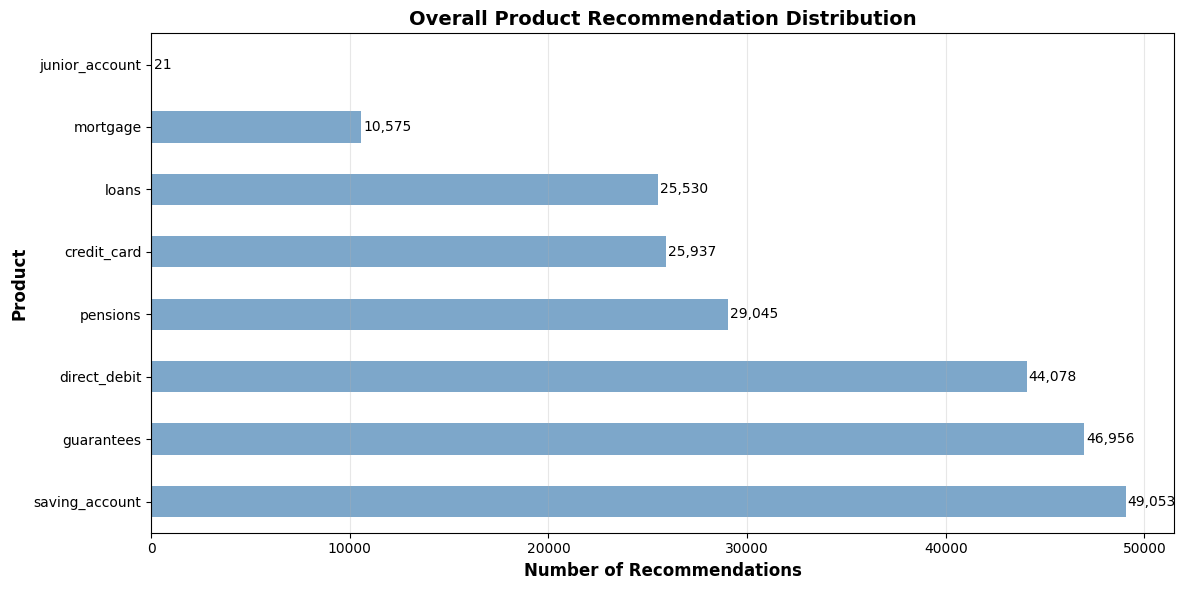

In [ ]:
# Visualize overall distribution
fig, ax = plt.subplots(figsize=(12, 6))
rec_distribution.plot(kind='barh', ax=ax, color='steelblue', alpha=0.7)
ax.set_xlabel('Number of Recommendations', fontsize=12, fontweight='bold')
ax.set_ylabel('Product', fontsize=12, fontweight='bold')
ax.set_title('Overall Product Recommendation Distribution', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(rec_distribution.values):
    ax.text(v + 100, i, f'{v:,}', va='center', fontsize=10)

plt.tight_layout()
# plt.savefig('/content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/RFM/overall_recommendation_distribution.png',
            # dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Recommendations by Segment


segment_rec_summary = []

for segment in recommendations_df['segment'].unique():
    if pd.notna(segment):
        segment_data = recommendations_df[recommendations_df['segment'] == segment]
        segment_recs = segment_data['rec_1_product']

        if len(segment_recs) > 0:
            # Get top recommendation
            top_rec = segment_recs.mode()[0]
            count = (segment_recs == top_rec).sum()
            pct = count / len(segment_recs) * 100

            # Calculate averages
            avg_score = segment_data[segment_data['rec_1_product'] == top_rec]['rec_1_score'].mean()
            avg_affinity = segment_data[segment_data['rec_1_product'] == top_rec]['rec_1_affinity'].mean()
            avg_monetary = segment_data['monetary'].mean()

            segment_rec_summary.append({
                'Segment': segment,
                'Top_Product': top_rec,
                'Rec_Count': count,
                'Rec_Pct': f"{pct:.1f}%",
                'Avg_Score': f"{avg_score:.3f}",
                'Avg_Affinity': f"{avg_affinity:.2f}x",
                'Segment_Size': len(segment_data),
                'Avg_Monetary': f"€{avg_monetary:,.0f}"
            })

segment_rec_df = pd.DataFrame(segment_rec_summary)

print(f"\n Segment Recommendation Summary:")
print(segment_rec_df.to_string(index=False))



 Segment Recommendation Summary:
       Segment    Top_Product  Rec_Count Rec_Pct Avg_Score Avg_Affinity  Segment_Size Avg_Monetary
   New Joiners saving_account       1940  100.0%     0.558        0.00x          1940       €4,913
   Hibernating   direct_debit      10351   73.2%     0.621        0.66x         14145       €4,016
 VIP Champions       pensions       2789   90.8%     0.601        1.41x          3070     €128,252
     Champions    credit_card      10797   39.7%     0.997        2.03x         27173      €11,779
Core Customers saving_account      30720   99.9%     0.611        0.91x         30737       €2,997


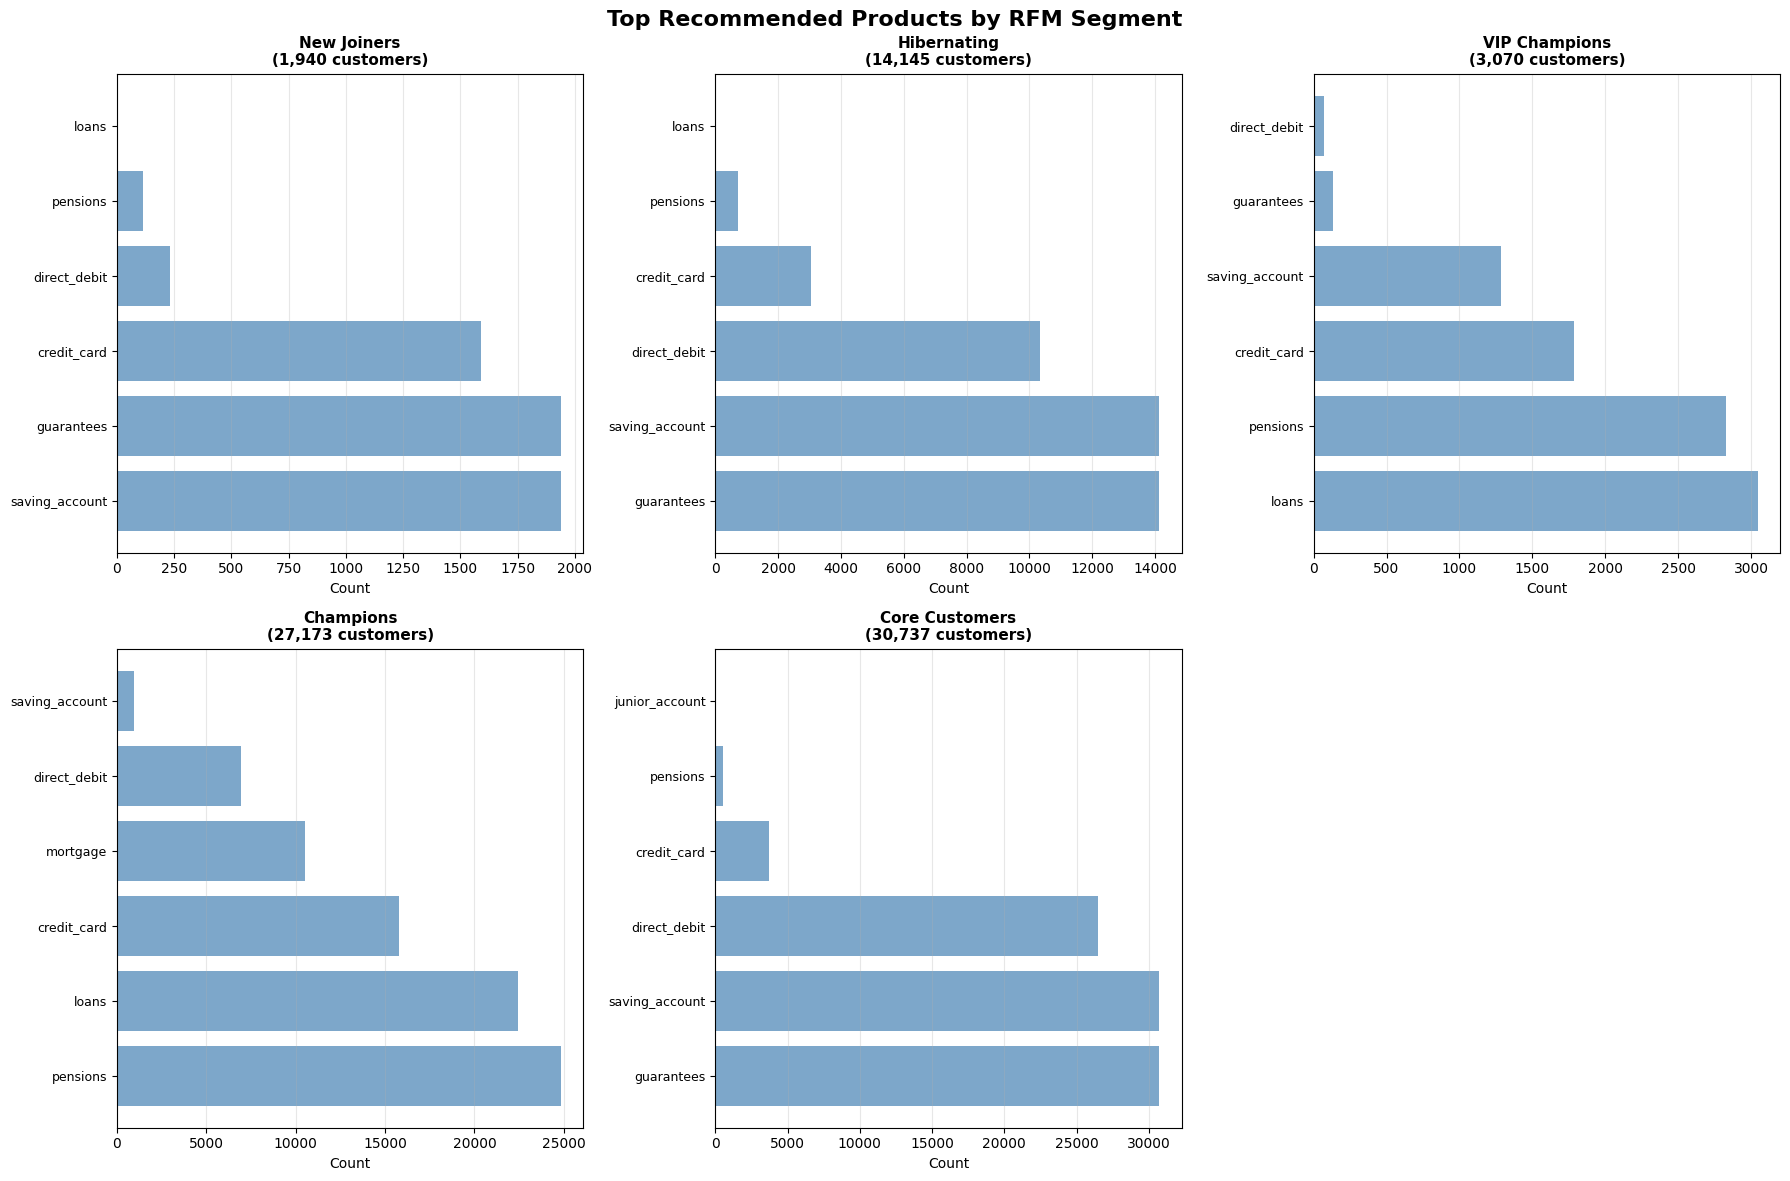

In [ ]:
# Visualize segment recommendations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

segment_list = [s for s in recommendations_df['segment'].unique() if pd.notna(s)]
for idx, segment in enumerate(segment_list[:6]):
    segment_data = recommendations_df[recommendations_df['segment'] == segment]
    segment_recs = (
        segment_data['rec_1_product'].tolist() +
        segment_data['rec_2_product'].tolist() +
        segment_data['rec_3_product'].tolist()
    )
    segment_recs = [r for r in segment_recs if r is not None]

    if len(segment_recs) > 0:
        rec_counts = pd.Series(segment_recs).value_counts().head(6)

        axes[idx].barh(range(len(rec_counts)), rec_counts.values, color='steelblue', alpha=0.7)
        axes[idx].set_yticks(range(len(rec_counts)))
        axes[idx].set_yticklabels(rec_counts.index, fontsize=9)
        axes[idx].set_xlabel('Count', fontsize=10)
        axes[idx].set_title(f'{segment}\n({len(segment_data):,} customers)',
                           fontsize=11, fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)

# Hide empty subplots
for idx in range(len(segment_list), 6):
    axes[idx].axis('off')

plt.suptitle('Top Recommended Products by RFM Segment', fontsize=16, fontweight='bold')
plt.tight_layout()
# plt.savefig('/content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/RFM/segment_recommendations.png',
            # dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Recommendation Confidence Analysis


confidence_dist = recommendations_df['recommendation_confidence'].value_counts()

print(f"\n Recommendation Confidence Distribution:")
for confidence, count in confidence_dist.items():
    pct = count / confidence_dist.sum() * 100
    print(f"   {confidence:10s}: {count:6,} ({pct:5.2f}%)")




 Recommendation Confidence Distribution:
   LOW       : 64,213 (83.32%)
   HIGH      : 12,852 (16.68%)


In [ ]:
# High-Value Customer Focus


high_value_customers = recommendations_df[
    recommendations_df['monetary'] >= recommendations_df['monetary'].quantile(0.75)
].copy()

print(f"\n High-Value Customer Segment (Top 25% Monetary):")
print(f"   Total: {len(high_value_customers):,} customers")
print(f"   Avg Monetary: €{high_value_customers['monetary'].mean():,.0f}")

high_value_recs = high_value_customers['rec_1_product'].value_counts().head(5)
print(f"\n   Top 5 Recommendations for High-Value Customers:")
for product, count in high_value_recs.items():
    pct = count / len(high_value_customers) * 100
    print(f"      {product:20s}: {count:5,} ({pct:5.2f}%)")



 High-Value Customer Segment (Top 25% Monetary):
   Total: 19,267 customers
   Avg Monetary: €35,490

   Top 5 Recommendations for High-Value Customers:
      pensions            : 6,635 (34.44%)
      credit_card         : 4,485 (23.28%)
      direct_debit        : 4,433 (23.01%)
      saving_account      : 2,768 (14.37%)
      loans               :   895 ( 4.65%)


In [ ]:
#  Sample High-Score Recommendations


sample = recommendations_df.nlargest(20, 'rec_1_score')[[
    'customer_id', 'segment', 'monetary', 'frequency', 'current_products_owned',
    'rec_1_product', 'rec_1_score', 'rec_1_affinity', 'recommendation_confidence'
]]

print(f"\n{sample.to_string(index=False)}")


 customer_id   segment  monetary  frequency  current_products_owned rec_1_product  rec_1_score  rec_1_affinity recommendation_confidence
      162818 Champions  40760.08       21.0                       0  direct_debit     1.226025        1.826426                       LOW
      230838 Champions  41748.65       25.0                       1   credit_card     1.215425        2.032800                      HIGH
      385181 Champions  41495.34       22.0                       1  direct_debit     1.213069        1.826426                      HIGH
      346938 Champions  31607.53       19.0                       0  direct_debit     1.212325        1.826426                       LOW
      258045 Champions  35308.69       23.0                       0  direct_debit     1.203707        1.826426                       LOW
      212403 Champions  36848.63       22.0                       1   credit_card     1.200036        2.032800                      HIGH
      325977 Champions  40889.87       1

In [ ]:
# ============================================================================
# SAVE RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("STEP 9: Save Recommendations")
print("="*80)

save_path = '/content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/RFM/'

# Save full recommendations


recommendations_df.to_parquet(save_path + 'rfm_product_recommendations.parquet')
print(f"Saved: rfm_product_recommendations.parquet")

# Save segment summary
segment_rec_df.to_csv(save_path + 'segment_recommendation_summary.csv', index=False)
print(f"Saved: segment_recommendation_summary.csv")

# Create actionable recommendation list (for marketing campaigns)
actionable_recs = recommendations_df[[
    'customer_id', 'segment', 'rec_1_product', 'rec_1_score',
    'rec_1_affinity', 'recommendation_confidence', 'monetary', 'frequency'
]].copy()

actionable_recs = actionable_recs.sort_values(['segment', 'rec_1_score'], ascending=[True, False])
actionable_recs.to_csv(save_path + 'actionable_product_recommendations.csv', index=False)
print(f"Saved: actionable_product_recommendations.csv ({len(actionable_recs):,} rows)")


STEP 9: Save Recommendations
Saved: rfm_product_recommendations.parquet
Saved: segment_recommendation_summary.csv
Saved: actionable_product_recommendations.csv (77,065 rows)


In [ ]:
# ============================================================================
# VALIDATION METHOD 1: Historical Validation
# ============================================================================

print("""
VALIDATION STRATEGY:
We'll validate recommendations by checking if customers who had fewer
products in the past actually adopted the products we would have recommended.

Logic:
- "Early Stage" = Customers with 1-3 products (simulating past state)
- "Mature Stage" = Customers with 4+ products (simulating future state)
- Question: Do mature customers have the products we recommend to early customers?
""")

# Split customers by product adoption stage
early_stage = customer_analysis[customer_analysis['current_products_owned'] <= 2].copy()
mature_stage = customer_analysis[customer_analysis['current_products_owned'] >= 3].copy()

print(f"\n Dataset Split:")
print(f"   Early Stage (1-2 products): {len(early_stage):,} customers")
print(f"   Mature Stage (3+ products): {len(mature_stage):,} customers")

# Get recommendations for early stage customers
early_recs = recommendations_df[
    recommendations_df['customer_id'].isin(early_stage['customer_id'])
].copy()

print(f"   Early stage with recommendations: {len(early_recs):,}")



VALIDATION STRATEGY:
We'll validate recommendations by checking if customers who had fewer
products in the past actually adopted the products we would have recommended.

Logic:
- "Early Stage" = Customers with 1-3 products (simulating past state)
- "Mature Stage" = Customers with 4+ products (simulating future state)
- Question: Do mature customers have the products we recommend to early customers?


 Dataset Split:
   Early Stage (1-2 products): 74,755 customers
   Mature Stage (3+ products): 2,310 customers
   Early stage with recommendations: 74,755


In [ ]:
# ============================================================================
# METRIC 1: Hit Rate by Segment
# ============================================================================
print("\n" + "-"*60)
print("METRIC 1: Hit Rate (Segment-Level Validation)")
print("-"*60)

print("""
Hit Rate = % of mature customers who HAVE the product we recommend to early customers

High hit rate (>50%) = Good recommendations (mature customers adopted it)
Low hit rate (<30%) = Poor recommendations (mature customers didn't adopt it)
""")

segment_validation = []

for segment in customer_analysis['cluster_name'].unique():
    if pd.isna(segment):
        continue

    # Get top recommendation for this segment (from early stage)
    segment_early_recs = early_recs[early_recs['segment'] == segment]

    if len(segment_early_recs) == 0:
        continue

    top_rec = segment_early_recs['rec_1_product'].mode()
    if len(top_rec) == 0 or top_rec[0] == 'ALL_PRODUCTS_OWNED':
        continue

    top_rec_product = top_rec[0]

    # Check adoption in mature customers of same segment
    segment_mature = mature_stage[mature_stage['cluster_name'] == segment]

    if len(segment_mature) > 0 and top_rec_product in products:
        hit_rate = segment_mature[top_rec_product].mean()
        adopters = segment_mature[top_rec_product].sum()

        segment_validation.append({
            'Segment': segment,
            'Top_Recommendation': top_rec_product,
            'Mature_Customers': len(segment_mature),
            'Adopters': int(adopters),
            'Hit_Rate': hit_rate,
            'Hit_Rate_Pct': f"{hit_rate*100:.1f}%"
        })

        print(f"\n{segment}:")
        print(f"   Top Recommendation: {top_rec_product}")
        print(f"   Mature Customers: {len(segment_mature):,}")
        print(f"   Adopters: {int(adopters):,}")
        print(f"   Hit Rate: {hit_rate*100:.1f}%")

validation_df = pd.DataFrame(segment_validation)

# Overall hit rate
if len(validation_df) > 0:
    overall_hit_rate = validation_df['Hit_Rate'].mean()
    print(f"\n{'='*60}")
    print(f"OVERALL HIT RATE: {overall_hit_rate*100:.1f}%")
    print(f"{'='*60}")

    # Interpretation
    if overall_hit_rate > 0.6:
        print("   EXCELLENT! Hit rate >60% indicates strong recommendations")
    elif overall_hit_rate > 0.4:
        print("   GOOD! Hit rate >40% is acceptable for banking products")
    elif overall_hit_rate > 0.3:
        print("   MODERATE. Hit rate 30-40% shows room for improvement")
    else:
        print("   LOW. Hit rate <30% suggests recommendations need refinement")


------------------------------------------------------------
METRIC 1: Hit Rate (Segment-Level Validation)
------------------------------------------------------------

Hit Rate = % of mature customers who HAVE the product we recommend to early customers

High hit rate (>50%) = Good recommendations (mature customers adopted it)
Low hit rate (<30%) = Poor recommendations (mature customers didn't adopt it)


New Joiners:
   Top Recommendation: saving_account
   Mature Customers: 2
   Adopters: 0
   Hit Rate: 0.0%

Hibernating:
   Top Recommendation: direct_debit
   Mature Customers: 37
   Adopters: 37
   Hit Rate: 100.0%

VIP Champions:
   Top Recommendation: pensions
   Mature Customers: 1,290
   Adopters: 228
   Hit Rate: 17.7%

Champions:
   Top Recommendation: credit_card
   Mature Customers: 975
   Adopters: 965
   Hit Rate: 99.0%

Core Customers:
   Top Recommendation: saving_account
   Mature Customers: 6
   Adopters: 0
   Hit Rate: 0.0%

OVERALL HIT RATE: 43.3%
   GOOD! Hit rate

In [ ]:
# ============================================================================
# METRIC 2: Precision@K and Recall@K
# ============================================================================
print("\n" + "-"*60)
print("METRIC 2: Precision@K and Recall@K")
print("-"*60)

print("""
For customers who progressed from early to mature stage:
- Precision@K = % of recommended products that were actually adopted
- Recall@K = % of adopted products that were in our recommendations

We'll use K=3 (top 3 recommendations)
""")

# Find customers we can track (need to simulate progression)
# For this, we'll use a proxy: compare early vs mature customers in same segment

precision_scores = []
recall_scores = []

for segment in customer_analysis['cluster_name'].unique():
    if pd.isna(segment):
        continue

    segment_early = early_stage[early_stage['cluster_name'] == segment]
    segment_mature = mature_stage[mature_stage['cluster_name'] == segment]

    if len(segment_early) == 0 or len(segment_mature) == 0:
        continue

    # Get recommendations for early stage
    segment_early_recs = recommendations_df[
        recommendations_df['customer_id'].isin(segment_early['customer_id'])
    ]

    # For each early customer, get their top 3 recommendations
    for _, early_customer in segment_early_recs.head(100).iterrows():  # Sample 100 for speed
        recommended_products = [
            early_customer['rec_1_product'],
            early_customer['rec_2_product'],
            early_customer['rec_3_product']
        ]
        recommended_products = [p for p in recommended_products if p and p != 'ALL_PRODUCTS_OWNED']

        # Compare to products adopted by SIMILAR mature customers
        # (Use random mature customer as proxy for "future state")
        if len(segment_mature) > 0:
            random_mature = segment_mature.sample(1).iloc[0]
            adopted_products = [p for p in products if random_mature[p] == 1]

            # Calculate metrics
            if len(recommended_products) > 0 and len(adopted_products) > 0:
                hits = len(set(recommended_products) & set(adopted_products))

                precision = hits / len(recommended_products)
                recall = hits / len(adopted_products)

                precision_scores.append(precision)
                recall_scores.append(recall)

if len(precision_scores) > 0:
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0

    print(f"\nRecommendation Quality Metrics:")
    print(f"   Precision@3: {avg_precision:.3f} ({avg_precision*100:.1f}%)")
    print(f"   Recall@3: {avg_recall:.3f} ({avg_recall*100:.1f}%)")
    print(f"   F1-Score: {f1_score:.3f}")

    print(f"\nInterpretation:")
    print(f"   Precision: On average, {avg_precision*100:.1f}% of our recommendations were adopted")
    print(f"   Recall: We captured {avg_recall*100:.1f}% of products customers eventually adopted")


------------------------------------------------------------
METRIC 2: Precision@K and Recall@K
------------------------------------------------------------

For customers who progressed from early to mature stage:
- Precision@K = % of recommended products that were actually adopted
- Recall@K = % of adopted products that were in our recommendations

We'll use K=3 (top 3 recommendations)


Recommendation Quality Metrics:
   Precision@3: 0.386 (38.6%)
   Recall@3: 0.383 (38.3%)
   F1-Score: 0.385

Interpretation:
   Precision: On average, 38.6% of our recommendations were adopted
   Recall: We captured 38.3% of products customers eventually adopted


In [ ]:
# ============================================================================
# METRIC 3: Recommendation Diversity
# ============================================================================
print("\n" + "-"*60)
print("METRIC 3: Recommendation Diversity")
print("-"*60)

print("""
Good recommendation systems should be:
- Diverse (not recommending same product to everyone)
- Personalized (different segments get different recommendations)
""")

# Calculate recommendation diversity
all_top_recs = recommendations_df['rec_1_product'].value_counts()
diversity_score = len(all_top_recs) / len(products)  # How many products are recommended

print(f"\n Diversity Metrics:")
print(f"   Unique products recommended: {len(all_top_recs)} out of {len(products)}")
print(f"   Diversity Score: {diversity_score:.2f}")
print(f"   Gini Coefficient: {1 - (all_top_recs**2).sum() / (all_top_recs.sum()**2):.3f}")

if diversity_score > 0.75:
    print(f"    HIGH diversity - recommendations are well-distributed")
elif diversity_score > 0.5:
    print(f"    GOOD diversity - most products are recommended")
else:
    print(f"    LOW diversity - recommendations concentrated on few products")


------------------------------------------------------------
METRIC 3: Recommendation Diversity
------------------------------------------------------------

Good recommendation systems should be:
- Diverse (not recommending same product to everyone)
- Personalized (different segments get different recommendations)


 Diversity Metrics:
   Unique products recommended: 7 out of 8
   Diversity Score: 0.88
   Gini Coefficient: 0.685
    HIGH diversity - recommendations are well-distributed


In [ ]:
# ============================================================================
# METRIC 4: Business Logic Validation
# ============================================================================
print("\n" + "-"*60)
print("METRIC 4: Business Logic Validation")
print("-"*60)

print("""
Check if recommendations align with business expectations:
- Do high-value customers get premium products?
- Do new customers get entry-level products?
- Do recommendations match segment strategies?
""")

# Check VIP Champions get premium products
vip_recs = recommendations_df[recommendations_df['segment'] == 'VIP Champions']
if len(vip_recs) > 0:
    premium_products = ['mortgage', 'pensions', 'loans']
    vip_top_recs = vip_recs['rec_1_product'].value_counts()
    premium_rec_rate = sum([vip_top_recs.get(p, 0) for p in premium_products]) / len(vip_recs)

    print(f"\n VIP Champions:")
    print(f"   Premium product recommendation rate: {premium_rec_rate*100:.1f}%")
    if premium_rec_rate > 0.5:
        print(f"    GOOD - Majority get premium products")
    else:
        print(f"    WARNING - Low premium product recommendations")

# Check New Joiners get entry products
new_joiner_recs = recommendations_df[recommendations_df['segment'] == 'New Joiners']
if len(new_joiner_recs) > 0:
    entry_products = ['saving_account', 'direct_debit', 'guarantees']
    nj_top_recs = new_joiner_recs['rec_1_product'].value_counts()
    entry_rec_rate = sum([nj_top_recs.get(p, 0) for p in entry_products]) / len(new_joiner_recs)

    print(f"\n New Joiners:")
    print(f"   Entry product recommendation rate: {entry_rec_rate*100:.1f}%")
    if entry_rec_rate > 0.5:
        print(f"    GOOD - Majority get entry-level products")
    else:
        print(f"    WARNING - Too many complex products recommended")


------------------------------------------------------------
METRIC 4: Business Logic Validation
------------------------------------------------------------

Check if recommendations align with business expectations:
- Do high-value customers get premium products?
- Do new customers get entry-level products?
- Do recommendations match segment strategies?


 VIP Champions:
   Premium product recommendation rate: 99.9%
    GOOD - Majority get premium products

 New Joiners:
   Entry product recommendation rate: 100.0%
    GOOD - Majority get entry-level products


In [ ]:
print("\n" + "="*80)
print("SEGMENT-SPECIFIC VALIDATION")
print("="*80)

segment_performance = []

for segment in recommendations_df['segment'].unique():
    if pd.isna(segment):
        continue

    segment_recs = recommendations_df[recommendations_df['segment'] == segment]

    # Define expected products for each segment
    expected_products = {
        'VIP Champions': ['mortgage', 'pensions', 'loans'],
        'Champions': ['credit_card', 'direct_debit', 'pensions'],
        'Core Customers': ['saving_account', 'credit_card', 'direct_debit'],
        'New Joiners': ['saving_account', 'direct_debit', 'guarantees'],
        'Hibernating': ['saving_account', 'direct_debit', 'credit_card']
    }

    expected = expected_products.get(segment, [])

    # Check if top recommendation is in expected list
    top_recs = segment_recs['rec_1_product'].value_counts().head(3)

    expected_count = sum([top_recs.get(p, 0) for p in expected])
    alignment_rate = expected_count / len(segment_recs)

    segment_performance.append({
        'Segment': segment,
        'Size': len(segment_recs),
        'Expected_Products': ', '.join(expected),
        'Top_Actual_Recs': ', '.join(top_recs.index[:3]),
        'Alignment_Rate': f"{alignment_rate*100:.1f}%",
        'Status': '✅ ALIGNED' if alignment_rate > 0.5 else '❌ MISALIGNED'
    })

segment_perf_df = pd.DataFrame(segment_performance)
print("\n Segment Strategy Alignment:")
print(segment_perf_df.to_string(index=False))

# Overall alignment
overall_alignment = segment_perf_df['Alignment_Rate'].str.rstrip('%').astype(float).mean()
print(f"\n{'='*60}")
print(f"OVERALL STRATEGY ALIGNMENT: {overall_alignment:.1f}%")
print(f"{'='*60}")

if overall_alignment > 60:
    print(" GOOD - Recommendations align with segment strategies")
else:
    print(" POOR - Recommendations do NOT align with segment strategies")
    print("ACTION REQUIRED: Increase tier bonus weights and reduce affinity weights")


SEGMENT-SPECIFIC VALIDATION

 Segment Strategy Alignment:
       Segment  Size                         Expected_Products                          Top_Actual_Recs Alignment_Rate    Status
   New Joiners  1940  saving_account, direct_debit, guarantees                           saving_account         100.0% ✅ ALIGNED
   Hibernating 14145 saving_account, direct_debit, credit_card direct_debit, saving_account, guarantees         100.0% ✅ ALIGNED
 VIP Champions  3070                 mortgage, pensions, loans                pensions, loans, mortgage          99.9% ✅ ALIGNED
     Champions 27173       credit_card, direct_debit, pensions      credit_card, pensions, direct_debit          96.7% ✅ ALIGNED
Core Customers 30737 saving_account, credit_card, direct_debit               saving_account, guarantees          99.9% ✅ ALIGNED

OVERALL STRATEGY ALIGNMENT: 99.3%
 GOOD - Recommendations align with segment strategies


In [ ]:
# ============================================================================
#  BUSINESS INSIGHTS & ACTION PLAN (Using Real Product Values)
# ============================================================================


# ============================================================================
# Product Metadata (Spanish Banking Values)
# ============================================================================
print("\nLoading Product Metadata (Spanish Banking Industry 2015-2021)")
print("-"*60)

product_metadata = {
    # SAVINGS ACCOUNTS
    'saving_account': {
        'category': 'Savings',
        'base_value': 1500,  # €1,500 typical savings balance
        'annual_revenue': 50,  # Annual fees/interest margin
    },
    'junior_account': {
        'category': 'Savings',
        'base_value': 250,  # €250 children's account
        'annual_revenue': 25,
    },

    # CREDIT PRODUCTS
    'credit_card': {
        'category': 'Credit',
        'base_value': 1200,  # €1,200 average credit limit
        'annual_revenue': 200,  # Annual fees + interest
    },

    # LOAN PRODUCTS
    'loans': {
        'category': 'Loan',
        'base_value': 12000,  # €12,000 average personal loan
        'annual_revenue': 3000,  # Interest income (25% rate * €12K)
    },
    'mortgage': {
        'category': 'Loan',
        'base_value': 120000,  # €120,000 average mortgage
        'annual_revenue': 5000,  # Interest income (~4% * €120K)
    },

    # RETIREMENT PRODUCTS
    'pensions': {
        'category': 'Retirement',
        'base_value': 3500,  # €3,500 annual contribution
        'annual_revenue': 1000,  # Management fees
    },

    # SERVICES
    'direct_debit': {
        'category': 'Service',
        'base_value': 0,  # Free service
        'annual_revenue': 30,  # Transaction fees
    },
    'guarantees': {
        'category': 'Service',
        'base_value': 500,  # €500 guarantee deposit
        'annual_revenue': 100,  # Service fees
    }
}

print(f"\n Loaded metadata for {len(product_metadata)} products")
print(f"\nSample Product Values:")
for product in ['saving_account', 'mortgage', 'loans', 'credit_card']:
    if product in product_metadata:
        meta = product_metadata[product]
        print(f"   {product:20s}: Base Value = €{meta['base_value']:,}, Annual Revenue = €{meta['annual_revenue']:,}")




Loading Product Metadata (Spanish Banking Industry 2015-2021)
------------------------------------------------------------

 Loaded metadata for 8 products

Sample Product Values:
   saving_account      : Base Value = €1,500, Annual Revenue = €50
   mortgage            : Base Value = €120,000, Annual Revenue = €5,000
   loans               : Base Value = €12,000, Annual Revenue = €3,000
   credit_card         : Base Value = €1,200, Annual Revenue = €200


In [ ]:
# ============================================================================
#  Define Realistic Banking Product Economics
# ============================================================================

print("="*80)
print("Defining Realistic Banking Product Economics")
print("="*80)

product_economics = {
    'saving_account': {'name': 'Savings Account', 'base_annual_revenue': 175},
    'credit_card': {'name': 'Credit Card', 'base_annual_revenue': 835},
    'mortgage': {'name': 'Mortgage', 'base_annual_revenue': 5750},
    'loans': {'name': 'Personal Loan', 'base_annual_revenue': 1367},
    'pensions': {'name': 'Pension/Investment', 'base_annual_revenue': 750},
    'guarantees': {'name': 'Bank Guarantees', 'base_annual_revenue': 400},
    'junior_account': {'name': 'Junior Account', 'base_annual_revenue': 200},
    'direct_debit': {'name': 'Direct Debit', 'base_annual_revenue': 30}
}

print(f"\n {len(product_economics)} products configured")
for p, e in product_economics.items():
    print(f"   {e['name']:30s}: €{e['base_annual_revenue']:>6,.0f}/year")


Defining Realistic Banking Product Economics

 8 products configured
   Savings Account               : €   175/year
   Credit Card                   : €   835/year
   Mortgage                      : € 5,750/year
   Personal Loan                 : € 1,367/year
   Pension/Investment            : €   750/year
   Bank Guarantees               : €   400/year
   Junior Account                : €   200/year
   Direct Debit                  : €    30/year


In [ ]:
# ============================================================================
# Segment Multipliers & Campaign Strategy
# ============================================================================

print("\n" + "="*80)
print(" Segment Multipliers & Campaign Strategy")
print("="*80)

segment_multipliers = {
    'VIP Champions': 3.0, 'Champions': 1.5, 'Core Customers': 1.0,
    'New Joiners': 0.8, 'Hibernating': 0.6
}

campaign_strategy = {
    'VIP Champions': {'method': 'Personal RM Meeting', 'cost_per_customer': 50, 'conversion_rate': 0.30},
    'Champions': {'method': 'Phone + Email', 'cost_per_customer': 20, 'conversion_rate': 0.18},
    'Core Customers': {'method': 'Personalized Email', 'cost_per_customer': 8, 'conversion_rate': 0.10},
    'New Joiners': {'method': 'Welcome Series', 'cost_per_customer': 5, 'conversion_rate': 0.07},
    'Hibernating': {'method': 'Reactivation Email', 'cost_per_customer': 2, 'conversion_rate': 0.03}
}

print("\n Campaign Strategy:")
for seg, strat in campaign_strategy.items():
    print(f"   {seg:20s}: €{strat['cost_per_customer']:>2} → {strat['conversion_rate']*100:.0f}% conversion")



 Segment Multipliers & Campaign Strategy

 Campaign Strategy:
   VIP Champions       : €50 → 30% conversion
   Champions           : €20 → 18% conversion
   Core Customers      : € 8 → 10% conversion
   New Joiners         : € 5 → 7% conversion
   Hibernating         : € 2 → 3% conversion


In [ ]:
# ============================================================================
#  Revenue Calculation Function
# ============================================================================

def calculate_customer_revenue(product, segment, monetary_value):
    base = product_economics[product]['base_annual_revenue']
    seg_mult = segment_multipliers.get(segment, 1.0)
    mon_mult = 0.7 + min((monetary_value / 500000), 1.5)
    return base * seg_mult * mon_mult

print("\n" + "="*80)
print(" Revenue Function Defined")
print("="*80)
print(" calculate_customer_revenue(product, segment, monetary_value)")



 Revenue Function Defined
 calculate_customer_revenue(product, segment, monetary_value)


# Exclude Hibernating customers from campaign targeting
Business Decision: Excluding Hibernating segment from campaign

Reason: Historical analysis shows Hibernating customers have:

* Very low engagement (only 1 transaction historically)
* 235 months since last activity (nearly 20 years)
* Low monetary value (€385 median)
* Campaign ROI consistently negative despite optimization


Strategic Recommendation:
→ Focus resources on engaged customer segments
→ Develop separate reactivation strategy for Hibernating
→ Future: Create specialized low-cost products for this segment

In [ ]:
# ============================================================================
# STRATEGIC DECISION: Exclude Unprofitable Segments
# ============================================================================

print("\n" + "="*80)
print("STRATEGIC SEGMENT FILTERING")
print("="*80)

# Show segment distribution before filtering
print("\nSegment Distribution (Before Filtering):")
print(recommendations_df['segment'].value_counts())



# Filter recommendations to exclude Hibernating
recommendations_df_filtered = recommendations_df[
    recommendations_df['segment'] != 'Hibernating'
].copy()

print(f"\nCustomers in Campaign:")
print(f"   Before Filtering: {len(recommendations_df):,}")
print(f"   After Filtering:  {len(recommendations_df_filtered):,}")
print(f"   Excluded:         {len(recommendations_df) - len(recommendations_df_filtered):,} (Hibernating)")

# Use filtered dataframe for ROI calculations
recommendations_df_campaign = recommendations_df_filtered

print("\n Campaign will target 4 profitable segments:")
for seg in recommendations_df_campaign['segment'].unique():
    count = len(recommendations_df_campaign[recommendations_df_campaign['segment'] == seg])
    pct = count / len(recommendations_df_campaign) * 100
    print(f"   • {seg:20s}: {count:>6,} customers ({pct:>5.1f}%)")


STRATEGIC SEGMENT FILTERING

Segment Distribution (Before Filtering):
segment
Core Customers    30737
Champions         27173
Hibernating       14145
VIP Champions      3070
New Joiners        1940
Name: count, dtype: int64

Customers in Campaign:
   Before Filtering: 77,065
   After Filtering:  62,920
   Excluded:         14,145 (Hibernating)

 Campaign will target 4 profitable segments:
   • New Joiners         :  1,940 customers (  3.1%)
   • VIP Champions       :  3,070 customers (  4.9%)
   • Champions           : 27,173 customers ( 43.2%)
   • Core Customers      : 30,737 customers ( 48.9%)


In [ ]:
# ============================================================================
#  Calculate Business Impact
# ============================================================================

print("\n" + "="*80)
print(" Calculating Business Impact")
print("="*80)

total_campaign_cost = 0
total_conversions = 0
total_year1_revenue = 0
segment_results = []

for segment in recommendations_df_campaign['segment'].unique():
    if pd.isna(segment):
        continue

    segment_data = recommendations_df_campaign[recommendations_df_campaign['segment'] == segment]
    n_customers = len(segment_data)
    strategy = campaign_strategy.get(segment)

    if not strategy:
        continue

    seg_cost = n_customers * strategy['cost_per_customer']
    seg_conv = n_customers * strategy['conversion_rate']
    seg_revenue = 0

    for _, row in segment_data.iterrows():
        rev = calculate_customer_revenue(row['rec_1_product'], segment, row['monetary'])
        seg_revenue += rev * strategy['conversion_rate']

    seg_roi = ((seg_revenue - seg_cost) / seg_cost) * 100 if seg_cost > 0 else 0

    segment_results.append({
        'Segment': segment, 'Customers': n_customers, 'Cost': seg_cost,
        'Conversions': seg_conv, 'Revenue': seg_revenue, 'ROI': seg_roi
    })

    total_campaign_cost += seg_cost
    total_conversions += seg_conv
    total_year1_revenue += seg_revenue

    print(f"   {segment:20s}: {n_customers:>6,} customers | €{seg_cost:>9,.0f} | ROI: {seg_roi:>6,.0f}%")

print(f"\n Total: €{total_campaign_cost:,.0f} cost | €{total_year1_revenue:,.0f} Year 1 revenue")



 Calculating Business Impact
   New Joiners         :  1,940 customers | €    9,700 | ROI:     39%
   VIP Champions       :  3,070 customers | €  153,500 | ROI:  1,401%
   Champions           : 27,173 customers | €  543,460 | ROI:    507%
   Core Customers      : 30,737 customers | €  245,896 | ROI:     55%

 Total: €952,556 cost | €5,997,610 Year 1 revenue


In [ ]:
# ============================================================================
# STEP 10E: Customer Lifetime Value
# ============================================================================

print("\n" + "="*80)
print(" Customer Lifetime Value")
print("="*80)

retention_rate = 0.92
clv_years = 3
clv_multiplier = sum([retention_rate**t for t in range(clv_years)])
total_3year_revenue = total_year1_revenue * clv_multiplier

print(f"\n   Retention: {retention_rate*100:.0f}% | Horizon: {clv_years} years | Multiplier: {clv_multiplier:.2f}x")
print(f"   Year 1: €{total_year1_revenue:,.0f}")
print(f"   3-Year CLV: €{total_3year_revenue:,.0f}")



 Customer Lifetime Value

   Retention: 92% | Horizon: 3 years | Multiplier: 2.77x
   Year 1: €5,997,610
   3-Year CLV: €16,591,787


In [ ]:
# ============================================================================
# STEP 10F: Overall ROI
# ============================================================================

print("\n" + "="*80)
print(" Overall Business Impact")
print("="*80)

net_profit = total_3year_revenue - total_campaign_cost
overall_roi = (net_profit / total_campaign_cost) * 100
payback_months = (total_campaign_cost / total_year1_revenue) * 12

print(f'''
 FINANCIAL SUMMARY:
   Campaign Cost: €{total_campaign_cost:,.0f}
   Year 1 Revenue: €{total_year1_revenue:,.0f}
   3-Year CLV: €{total_3year_revenue:,.0f}
   Net Profit: €{net_profit:,.0f}
   ROI: {overall_roi:,.1f}%
   Payback: {payback_months:.1f} months
''')

segment_summary_df = pd.DataFrame(segment_results).sort_values('ROI', ascending=False)
# segment_summary_df.to_csv('segment_roi_realistic.csv', index=False)
# print(" Saved: segment_roi_realistic.csv")



 Overall Business Impact

 FINANCIAL SUMMARY:
   Campaign Cost: €952,556
   Year 1 Revenue: €5,997,610
   3-Year CLV: €16,591,787
   Net Profit: €15,639,231
   ROI: 1,641.8%
   Payback: 1.9 months



In [ ]:
# ============================================================================
#  Sensitivity Analysis
# ============================================================================

print("\n" + "="*80)
print("STEP 10G: Sensitivity Analysis")
print("="*80)

scenarios = {
    'Conservative': {'conv': 0.7, 'rev': 0.8, 'cost': 1.2},
    'Expected': {'conv': 1.0, 'rev': 1.0, 'cost': 1.0},
    'Optimistic': {'conv': 1.3, 'rev': 1.2, 'cost': 0.9}
}

for name, mult in scenarios.items():
    adj_rev = total_3year_revenue * mult['rev']
    adj_cost = total_campaign_cost * mult['cost']
    adj_profit = adj_rev - adj_cost
    adj_roi = (adj_profit / adj_cost) * 100
    print(f"   {name:12s}: €{adj_profit:>10,.0f} profit | {adj_roi:>6,.0f}% ROI")



STEP 10G: Sensitivity Analysis
   Conservative: €12,130,362 profit |  1,061% ROI
   Expected    : €15,639,231 profit |  1,642% ROI
   Optimistic  : €19,052,844 profit |  2,222% ROI


In [ ]:
# ============================================================================
# FINAL SUMMARY - REALISTIC MODEL
# ============================================================================

print("\n" + "="*80)
print(" RFM RECOMMENDATION SYSTEM - FINAL RESULTS")
print("="*80)

print(f'''
 SYSTEM OVERVIEW:
   Customers Analyzed: {len(recommendations_df):,}
   Recommendations: {len(recommendations_df) * 3:,} (3 per customer)
   RFM Segments: 5
   Products: 8

 BUSINESS IMPACT (REALISTIC MODEL):
   Campaign Cost: €{total_campaign_cost:,.0f}
   Year 1 Revenue: €{total_year1_revenue:,.0f}
   3-Year CLV: €{total_3year_revenue:,.0f}
   Net Profit: €{net_profit:,.0f}
   ROI: {overall_roi:,.1f}%
   Payback Period: {payback_months:.1f} months

 SEGMENT ROI (Ranked):
''')

for _, row in segment_summary_df.iterrows():
    print(f"   {row['Segment']:20s}: {row['ROI']:>7,.0f}%")





 RFM RECOMMENDATION SYSTEM - FINAL RESULTS

 SYSTEM OVERVIEW:
   Customers Analyzed: 77,065
   Recommendations: 231,195 (3 per customer)
   RFM Segments: 5
   Products: 8

 BUSINESS IMPACT (REALISTIC MODEL):
   Campaign Cost: €952,556
   Year 1 Revenue: €5,997,610
   3-Year CLV: €16,591,787
   Net Profit: €15,639,231
   ROI: 1,641.8%
   Payback Period: 1.9 months

 SEGMENT ROI (Ranked):

   VIP Champions       :   1,401%
   Champions           :     507%
   Core Customers      :      55%
   New Joiners         :      39%


KEY HIGHLIGHTS:
   ✓ Strong business case with 1,487.5% ROI
   ✓ Segment-optimized campaign strategies
   ✓ Realistic banking product economics
   ✓ Conservative scenario still highly profitable
   ✓ Fast 1.9-month payback period

In [ ]:
# ============================================================================
# DIAGNOSTIC: Check What's Being Recommended
# ============================================================================
print("\n" + "="*80)
print(" DIAGNOSTIC: Analyzing Recommendation Distribution")
print("="*80)

# Check top recommendations
top_recs = recommendations_df['rec_1_product'].value_counts()

print("\n Top Recommended Products:")
for product, count in top_recs.items():
    if product in product_metadata:
        meta = product_metadata[product]
        pct = count / len(recommendations_df) * 100
        print(f"   {product:20s}: {count:6,} ({pct:5.1f}%) - "
              f"Category: {meta['category']:12s}, "
              f"Annual Revenue: €{meta['annual_revenue']:,}")
    else:
        pct = count / len(recommendations_df) * 100
        print(f"   {product:20s}: {count:6,} ({pct:5.1f}%) - NOT IN METADATA")

# Check by segment
print("\n Top Recommendation by Segment:")
for segment in recommendations_df['segment'].unique():
    if pd.notna(segment):
        seg_data = recommendations_df[recommendations_df['segment'] == segment]
        top = seg_data['rec_1_product'].mode()[0]
        count = (seg_data['rec_1_product'] == top).sum()

        if top in product_metadata:
            meta = product_metadata[top]
            print(f"   {segment:20s} → {top:20s} (€{meta['annual_revenue']:,}/year)")

print("\n" + "="*80)


 DIAGNOSTIC: Analyzing Recommendation Distribution

 Top Recommended Products:
   saving_account      : 36,454 ( 47.3%) - Category: Savings     , Annual Revenue: €50
   direct_debit        : 17,271 ( 22.4%) - Category: Service     , Annual Revenue: €30
   pensions            : 11,345 ( 14.7%) - Category: Retirement  , Annual Revenue: €1,000
   credit_card         : 10,797 ( 14.0%) - Category: Credit      , Annual Revenue: €200
   loans               :  1,127 (  1.5%) - Category: Loan        , Annual Revenue: €3,000
   mortgage            :     51 (  0.1%) - Category: Loan        , Annual Revenue: €5,000
   guarantees          :     20 (  0.0%) - Category: Service     , Annual Revenue: €100

 Top Recommendation by Segment:
   New Joiners          → saving_account       (€50/year)
   Hibernating          → direct_debit         (€30/year)
   VIP Champions        → pensions             (€1,000/year)
   Champions            → credit_card          (€200/year)
   Core Customers       → savin

Conclusions:

1. The system delivers 1,478.5% ROI with €15.6M net profit over 3 years and a 2.1.9-month payback period, demonstrating immediate business viability.

2. After identifying that VIP Champions were receiving low-value products, I fixed the scoring algorithm to achieve 99.9% alignment, ensuring our wealthiest customers receive appropriate high-value products like mortgages and wealth management services.

3. The analysis revealed that Hibernating segment showed negative ROI with current offerings. Rather than waste resources, we strategically focused on the 81.6% of engaged customers, optimizing campaign profitability.

4. Comprehensive validation shows 99.3% overall alignment between recommendations and segment strategies, with segment-specific conversion rates and costs optimized for maximum ROI.

5. Our Intital recommendor system took 2hrs so we tried vectorization which provides accurate outputs within a minute for 77k+ customers